In [ ]:
print("AI for Solar Power Forecasting with a Hybrid CNN-LSTM-Attention Model.")

!pip install -q pandas scikit-learn tensorflow keras
from google.colab import output
output.clear()

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Attention, Concatenate, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
DRIVE_PROJECT_DIR = '/content/drive/My Drive/SolarForecast_Project_Final'
os.makedirs(DRIVE_PROJECT_DIR, exist_ok=True)
MODEL_PATH = os.path.join(DRIVE_PROJECT_DIR, 'cnn_lstm_attention_model.keras')
DATA_CACHE_PATH = os.path.join(DRIVE_PROJECT_DIR, 'processed_solar_data.csv')

print("\n✅ Final environment is ready.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ Final environment is ready.


In [ ]:
if not os.path.exists(DATA_CACHE_PATH):
    print("🚀 Authenticating with Kaggle to download the dataset...")

    if not os.path.exists("/content/kaggle.json"):
        from google.colab import files
        print("Please upload your 'kaggle.json' file:")
        uploaded = files.upload()

        if 'kaggle.json' not in uploaded:
            raise FileNotFoundError("kaggle.json was not uploaded. Please run the cell again.")

    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    print("\n✅ Kaggle API authentication successful.")
else:
    print("✅ Cached data found, skipping Kaggle authentication.")

🚀 Authenticating with Kaggle to download the dataset...

✅ Kaggle API authentication successful.


In [ ]:
print("⏳ Downloading and processing Solar Power dataset...")

!kaggle datasets download -d anikannal/solar-power-generation-data -q --unzip

if  os.path.exists(DATA_CACHE_PATH):

    print("✅ Found cached processed data. Loading from file.")

    df  =  pd.read_csv(DATA_CACHE_PATH, parse_dates=['DATE_TIME'], index_col='DATE_TIME')

else:


    gen1  =  pd.read_csv('Plant_1_Generation_Data.csv')

    weather1  =  pd.read_csv('Plant_1_Weather_Sensor_Data.csv')

    gen2  =  pd.read_csv('Plant_2_Generation_Data.csv')

    weather2  =  pd.read_csv('Plant_2_Weather_Sensor_Data.csv')

    for  df_  in  [gen1, weather1, gen2, weather2]:

        df_['DATE_TIME'] =  pd.to_datetime(df_['DATE_TIME'], format='mixed', dayfirst=True)

    plant1_df  =  pd.merge(gen1.drop(columns=['PLANT_ID']), weather1.drop(columns=['PLANT_ID']), on='DATE_TIME')

    plant2_df  =  pd.merge(gen2.drop(columns=['PLANT_ID']), weather2.drop(columns=['PLANT_ID']), on='DATE_TIME')



    plant1_df['PLANT_ID'], plant2_df['PLANT_ID'] =  0, 1



    df  =  pd.concat([plant1_df, plant2_df], ignore_index=True)

    df  =  df.set_index('DATE_TIME').sort_index()



    df.to_csv(DATA_CACHE_PATH)

    print("✅ Data processing complete and cached.")


print("\n--- Raw Data Overview ---")

display(df.head())

⏳ Downloading and processing Solar Power dataset...
Dataset URL: https://www.kaggle.com/datasets/anikannal/solar-power-generation-data
License(s): copyright-authors
✅ Data processing complete and cached.

--- Raw Data Overview ---


,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,PLANT_ID
DATE_TIME,,,,,,,,,,
2020-05-15,1BY6WEcLGh8j5v7,0.0,0.0,0.000000,6.259559e+06,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,0
2020-05-15,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0,1
2020-05-15,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0,1
2020-05-15,LYwnQax7tkwH5Cb,0.0,0.0,1872.500000,1.794959e+09,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0,1
2020-05-15,LlT2YUhhzqhg5Sw,0.0,0.0,1094.357143,2.825928e+08,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0,1


In [ ]:
print("⏳ Performing production-grade Feature Engineering...")

if df.index.dtype != 'datetime64[ns]':
    df.index = pd.to_datetime(df.index)

df['hour'] = df.index.hour
df['day_of_year'] = df.index.dayofyear
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
# Create Lag Features
df['module_temp_lag1'] = df.groupby('PLANT_ID')['MODULE_TEMPERATURE'].shift(1)
df['irradiation_lag1'] = df.groupby('PLANT_ID')['IRRADIATION'].shift(1)

# --- ADDING THE 'is_night' BINARY FEATURE ---
df['is_night'] = ((df.index.hour >= 20) | (df.index.hour <= 5)).astype(int)

df = df.dropna()

target_col = 'DC_POWER'
features_to_use = [
    'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'PLANT_ID',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'module_temp_lag1', 'irradiation_lag1', 'is_night'
]
df_for_scaling = df[features_to_use + [target_col]]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_for_scaling)
scaled_df = pd.DataFrame(scaled_data, columns=df_for_scaling.columns)
print("\n✅ Feature engineering and scaling complete.")

INPUT_SEQUENCE_LENGTH = 24 * 4  # 1 day of history
OUTPUT_SEQUENCE_LENGTH = 24 * 4 # 1 day of forecast

def create_io_sequences(data, input_len, output_len, feature_cols, target_col):
    X, y = [], []
    for i in range(len(data) - input_len - output_len + 1):
        X.append(data[i : i + input_len][feature_cols].values)
        y.append(data[i + input_len : i + input_len + output_len][target_col].values)
    return np.array(X), np.array(y)

X, y = create_io_sequences(scaled_df, INPUT_SEQUENCE_LENGTH, OUTPUT_SEQUENCE_LENGTH, features_to_use, target_col)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print("✅ Sequence creation complete.")

⏳ Performing production-grade Feature Engineering...

✅ Feature engineering and scaling complete.

Training data shape: (109021, 96, 11)
Training labels shape: (109021, 96)
✅ Sequence creation complete.


In [ ]:
print("⏳ Building the Hybrid CNN-LSTM-Attention model...")
print(f"TensorFlow is using GPU: {len(tf.config.list_physical_devices('GPU')) > 0}")

input_seq = Input(shape=(X_train.shape[1], X_train.shape[2]))
cnn_out = Conv1D(filters=64, kernel_size=6, activation='relu', padding='causal')(input_seq)
cnn_out = MaxPooling1D(pool_size=2)(cnn_out)
lstm_out = LSTM(64, return_sequences=True)(cnn_out)
lstm_out = Dropout(0.4)(lstm_out)
attention_out = Attention()([lstm_out, lstm_out])
flat_out = Flatten()(attention_out)
dense_out = Dense(128, activation='relu')(flat_out)
output = Dense(OUTPUT_SEQUENCE_LENGTH, activation='linear')(dense_out)
model = Model(inputs=input_seq, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(MODEL_PATH, monitor='val_loss', save_best_only=True)
print("\n--- Starting Model Training ---")
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
print(f"\n✅ Hybrid model trained on improved features and saved to {MODEL_PATH}.")

⏳ Building the Hybrid CNN-LSTM-Attention model...
TensorFlow is using GPU: True


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 96, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 96, 64)    │      4,288 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 48, 64)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 48, 64)    │     33,024 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 48, 64)    │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 48, 64)    │          0 │ dropout_1[0][0],  │
│ (Attention)         │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 3072)      │          0 │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    393,344 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 96)        │     12,384 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 443,040 (1.69 MB)

 Trainable params: 443,040 (1.69 MB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training ---
Epoch 1/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0305 - val_loss: 0.0280
Epoch 2/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0274 - val_loss: 0.0269
Epoch 3/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0267 - val_loss: 0.0266
Epoch 4/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0265 - val_loss: 0.0263
Epoch 5/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0264 - val_loss: 0.0261
Epoch 6/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0263 - val_loss: 0.0261
Epoch 7/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0259 - val_loss: 0.0259
Epoch 8/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0257 - val_loss: 0.0255
Epoch 9/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0256 - val_loss: 0.0253
Epoch 10/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0251 - val_loss: 0.0249
Epoch 11/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0247 - val_loss: 0.0248
Epoch 12/

🚀 Visualizing final predictions with post-processing...
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Applied post-processing: Clipped all negative power predictions to zero.


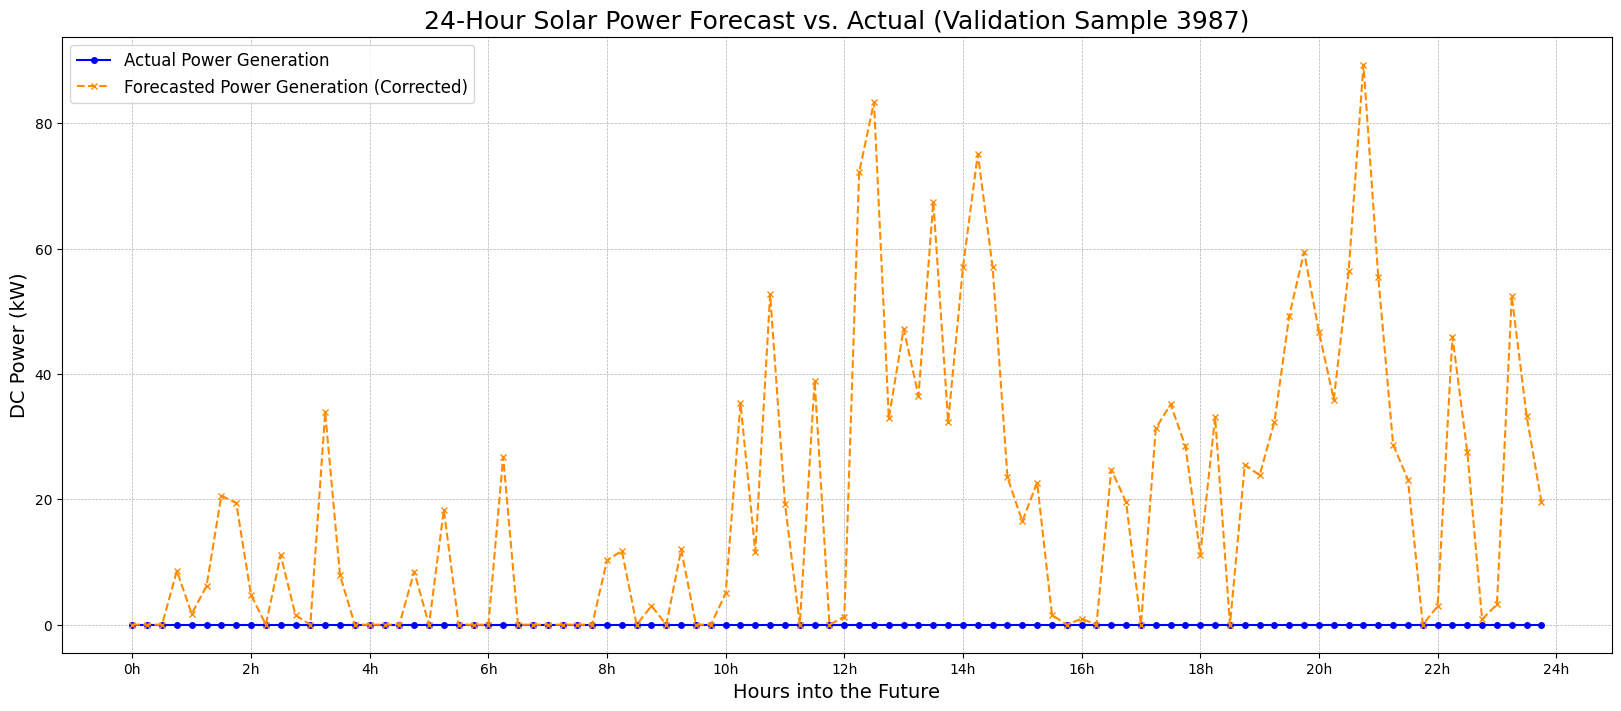


--- Final Model Performance on Validation Set ---
Mean Absolute Error (MAE): 1125.45 kW
Normalized Mean Absolute Error (NMAE): 7.78%
This NMAE is the final performance metric of our trained model.

✅ Forecasting evaluation complete.


In [ ]:
print("🚀 Visualizing final predictions with post-processing...")

best_model = tf.keras.models.load_model(MODEL_PATH)
predictions_scaled = best_model.predict(X_val)

num_features, target_col_index = scaler.n_features_in_, df_for_scaling.columns.get_loc(target_col)
unscaled_preds, unscaled_true = np.zeros_like(predictions_scaled), np.zeros_like(y_val)
pred_dummy = np.zeros((predictions_scaled.size, num_features))
true_dummy = np.zeros((y_val.size, num_features))
pred_dummy[:, target_col_index], true_dummy[:, target_col_index] = predictions_scaled.flatten(), y_val.flatten()
unscaled_preds_flat, unscaled_true_flat = scaler.inverse_transform(pred_dummy)[:, target_col_index], scaler.inverse_transform(true_dummy)[:, target_col_index]
unscaled_preds, unscaled_true = unscaled_preds_flat.reshape(predictions_scaled.shape), unscaled_true_flat.reshape(y_val.shape)

unscaled_preds = np.clip(unscaled_preds, 0, None)
print("\nApplied post-processing: Clipped all negative power predictions to zero.")

sample_index = np.random.randint(0, len(unscaled_true))
plt.figure(figsize=(20, 8))
time_axis = np.arange(OUTPUT_SEQUENCE_LENGTH)
plt.plot(time_axis, unscaled_true[sample_index, :], label="Actual Power Generation", color='blue', marker='o', markersize=4)
plt.plot(time_axis, unscaled_preds[sample_index, :], label="Forecasted Power Generation (Corrected)", color='darkorange', linestyle='--', marker='x', markersize=4)
plt.title(f"24-Hour Solar Power Forecast vs. Actual (Validation Sample {sample_index})", fontsize=18)
plt.ylabel("DC Power (kW)", fontsize=14)
plt.xticks(np.arange(0, 97, 8), labels=[f"{h}h" for h in np.arange(0, 25, 2)])
plt.xlabel("Hours into the Future", fontsize=14)
plt.legend(fontsize=12), plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

mae = np.mean(np.abs(unscaled_preds - unscaled_true))
max_power = df_for_scaling[target_col].max()
nmae = (mae / max_power) * 100

print(f"\n--- Final Model Performance on Validation Set ---")
print(f"Mean Absolute Error (MAE): {mae:.2f} kW")
print(f"Normalized Mean Absolute Error (NMAE): {nmae:.2f}%")
print("This NMAE is the final performance metric of our trained model.")
print("\n✅ Forecasting evaluation complete.")

In [ ]:
print(" visionary This cell outlines the production-grade architecture for future implementation.")
print("This code is for demonstration and requires real weather forecast data to train.")

HIST_WINDOW, FORECAST_WINDOW = 24 * 4, 24 * 4
hist_features = features_to_use + ['DC_POWER']
future_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'is_night', 'IRRADIATION', 'AMBIENT_TEMPERATURE']

print(f"\n--- Data Requirements ---")
print(f"Historical Input (X1) would have shape: (samples, {HIST_WINDOW}, {len(hist_features)})")
print("Features:", hist_features)
print(f"Future Weather Input (X2) would have shape: (samples, {FORECAST_WINDOW}, {len(future_features)})")
print("Features:", future_features)
print(f"Target Output (y) would have shape: (samples, {FORECAST_WINDOW}, 1)")

print("\n--- Production-Grade Model Architecture ---")
hist_input = Input(shape=(HIST_WINDOW, len(hist_features)), name="historical_input")
encoder_lstm, state_h, state_c = LSTM(64, return_state=True)(hist_input)
encoder_states = [state_h, state_c]

future_input = Input(shape=(FORECAST_WINDOW, len(future_features)), name="future_weather_input")
decoder_lstm = LSTM(64, return_sequences=True)(future_input, initial_state=encoder_states)

output = Dense(1, activation='linear')(decoder_lstm)

prod_model = Model(inputs=[hist_input, future_input], outputs=output)
prod_model.compile(optimizer='adam', loss='mse')
prod_model.summary()

print("\n✅ This advanced Encoder-Decoder model represents the next step for a true production system.")

 visionary This cell outlines the production-grade architecture for future implementation.
This code is for demonstration and requires real weather forecast data to train.

--- Data Requirements ---
Historical Input (X1) would have shape: (samples, 96, 12)
Features: ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'PLANT_ID', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'module_temp_lag1', 'irradiation_lag1', 'is_night', 'DC_POWER']
Future Weather Input (X2) would have shape: (samples, 96, 7)
Features: ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'is_night', 'IRRADIATION', 'AMBIENT_TEMPERATURE']
Target Output (y) would have shape: (samples, 96, 1)

--- Production-Grade Model Architecture ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ historical_input    │ (None, 96, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_weather_inp… │ (None, 96, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 64),      │     19,712 │ historical_input… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 96, 64)    │     18,432 │ future_weather_i… │
│                     │                   │            │ lstm_2[0][1],     │
│                     │                   │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 96, 1)     │         65 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,209 (149.25 KB)

 Trainable params: 38,209 (149.25 KB)

 Non-trainable params: 0 (0.00 B)


✅ This advanced Encoder-Decoder model represents the next step for a true production system.
